In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNLinkPredictor(nn.Module):
    def __init__(self, num_in_features, num_out_features=128, num_users=1):
        super().__init__()
        self.conv1 = GCNConv(num_in_features, num_out_features)
        self.conv2 = GCNConv(num_out_features, num_out_features)
        self.num_users = num_users

    def forward(self, x, edge_index):
        user_embedding = x[:self.num_users]
        movie_features = x[self.num_users:].detach()
        
        x = torch.cat([user_embedding, movie_features], dim=0)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x[self.num_users:] = movie_features
        return x

# 유저 - 영화 간 edge를 입력받아 유저-영화 간 관계 예측
class LinkPredictor(nn.Module):
    # 비선형으로 개선
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim * 2, input_dim)
        self.fc2 = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, z, edge_index):
        row, col = edge_index
        z_row = z[row]
        z_col = z[col]
        
        # 임베딩 연결
        z_concat = torch.cat([z_row, z_col], dim=1)
        
        # 비선형 활성화 함수
        x = F.relu(self.fc1(z_concat))
        
        # 정규화를 위한 드롭아웃
        x = self.dropout(x)
        
        # 두 번째 선형 계층 및 시그모이드 활성화 적용
        return torch.sigmoid(self.fc2(x))

In [23]:
num_in_features = 404
num_out_features = 404
num_users = 1

# load saved models
gcn_model = GCNLinkPredictor(num_in_features, num_out_features, num_users)
link_predictor = LinkPredictor(num_out_features)
gcn_model.load_state_dict(torch.load('gcn_model.pth'))
link_predictor.load_state_dict(torch.load('link_predictor.pth'))

# 모델을 evaluation 모드로 변경
gcn_model.eval()
link_predictor.eval()

LinkPredictor(
  (fc1): Linear(in_features=808, out_features=404, bias=True)
  (fc2): Linear(in_features=404, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
import pandas as pd

movie_metadata = pd.read_excel("cinemate_data_0511.xlsx")
final_metadata = pd.read_excel("final_metadata_with_overview_embeddings_ver5_0511.xlsx")

In [4]:
import numpy as np

# 유저 임베딩 생성 함수
def create_new_user_embedding(movie_features, interacted_movie_indices):
    new_user_embedding = movie_features[interacted_movie_indices].mean(dim=0)
    # print("new user embedding shape:", new_user_embedding.shape)
    # print("new user embedding:", new_user_embedding)
    return new_user_embedding

# 새로운 유저에 대한 영화 추천
def recommend_movies_for_new_user(node_embeddings, num_users = 1, num_movies = 9525, num_recommendations=5):
    movie_indices = torch.arange(num_users, num_users + num_movies) # 영화 인덱스 생성 (유저 수만큼 offset)
    
    # user-movie pairs 생성
    user_movie_pairs = torch.stack([torch.zeros(num_movies, dtype=torch.long), movie_indices], dim=0)
    print(user_movie_pairs)
    
    # user-movie pairs의 score 계산
    scores = link_predictor(node_embeddings, user_movie_pairs)
    # print(scores[scores > 0.9])
    
    # top N 추천
    _, top_indices = torch.topk(scores.squeeze(), num_recommendations)
    top_movie_indices = user_movie_pairs[1][top_indices] - num_users # 유저 수만큼 offset 재조정
    
    return top_movie_indices


# 영화 features
movie_features = torch.from_numpy(np.load("final_features_without_directors_0518.npy")).float()

# 새로운 유저가 6076, 9519 영화를 시청했다고 가정
# new_user_interacted_movies = [6076, 9519] # 점퍼, 메트로폴리스
# new_user_interacted_movies = [4887, 5839] # 7번 방의 선물, 세 얼간이
new_user_interacted_movies = [6, 10, 14] # Citizen of a Kind, It's Okay!, Deurim (코미디들)
new_user_embedding = create_new_user_embedding(movie_features, new_user_interacted_movies)

new_x = torch.cat([new_user_embedding.view(1, -1), movie_features], dim=0)
num_users = 1

# 유저 - 영화 간 상호작용 edge index로 변환
user_indices = [i for i in range(num_users)]
movie_indices = [i + num_users for i in new_user_interacted_movies]

edge_index = torch.tensor([user_indices * len(movie_indices), movie_indices], dtype=torch.long)

node_embeddings = gcn_model(new_x, edge_index)

# 새로운 유저에 대한 추천 수행
num_recommendations = 20
top_movies_for_new_user = recommend_movies_for_new_user(node_embeddings, num_recommendations=num_recommendations)
print(f"Top {num_recommendations} recommended movies for the new user: {top_movies_for_new_user}")
for idx in top_movies_for_new_user:
    print(final_metadata.iloc[int(idx)].genres)
    print(movie_metadata.iloc[int(idx)].overview)

tensor([[   0,    0,    0,  ...,    0,    0,    0],
        [   1,    2,    3,  ..., 9523, 9524, 9525]])
Top 20 recommended movies for the new user: tensor([4226, 5667, 1111,   55, 5804, 4737, 5276, 2260, 7599, 6529, 7706, 3675,
        4769, 5340, 3504, 1862, 9212, 8410, 5787, 6697])
Action,Crime
화려한 언변, 사람을 현혹하는 재능, 정관계를 넘나드는 인맥으로 수만 명 회원들에게 사기를 치며 승승장구해 온 원네트워크 진회장. 반년간 그를 추적해 온 지능범죄수사팀장 김재명은 진회장의 최측근인 박장군을 압박한다. 원네트워크 전산실 위치와 진회장의 로비 장부를 넘기라는 것. 뛰어난 프로그래밍 실력과 명석한 두뇌로 원네트워크를 키워 온 브레인 박장군은 계획에 차질이 생긴 것을 감지하자 빠르게 머리를 굴리기 시작한다. 진회장은 물론 그의 뒤에 숨은 권력까지 모조리 잡기 위해 포위망을 좁혀가는 재명,  오히려 이 기회를 틈타 돈도 챙기고 경찰의 압박에서도 벗어날 계획을 세우는 장군. 하지만 진회장은 간부 중에 배신자가 있음을 눈치채고, 새로운 플랜을 가동하는데…
Action,Crime,Drama
한 때 잘나가던 전직 형사이자 지금은 흥신소를 운영하는 강태식. 평범한 의뢰라고 생각하고 급습한 불륜 현장에 한 여자가 죽어 있다. 꼼짝없이 범인으로 몰리게 된 그 때, 걸려오는 전화 한 통 살인 누명을 벗으려면 누군가를 납치하라는 놈의 지시. 숨 돌릴 틈 없이 시작된 경찰의 추격, 자신의 일거수일투족은 물론, 과거 사연, 그리고 주변 인물까지 장악하고 있는 놈의 감시와 도청; 게다가 납치해야 하는 인물이 전국을 떠들썩하게 할 중요한 사건의 키를 쥐고 있다는 사실을 알게 된다. 이제, 자신을 조종하려는 놈과 실체를 알 수 없는 배후에 맞서 폭풍 같

# Consider Genres

In [2]:
import pandas as pd

df_for_genres_based_recommend = pd.read_excel("final_metadata_with_overview_embeddings_ver5_0511.xlsx")
df_for_genres_based_recommend

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,ordering,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,tt31015344,A Traveler's Needs,Yeohaengjaui Pilyo,2024,90,Drama,6.5,75,nm0393254,1,...,0.016458,-0.023006,-0.050298,0.037739,-0.076090,-0.010432,-0.058701,0.017649,0.035267,-0.023228
1,tt30911335,Dog Days,Dogeudeijeu,2024,120,Drama,7.8,31,nm15730187,1,...,-0.034701,-0.008065,-0.024117,-0.003312,0.038821,-0.030186,0.019926,0.074339,-0.018989,0.055851
2,tt9682428,Night Swim,Night Swim,2024,98,"Horror,Thriller",4.7,12654,nm3241399,1,...,0.003738,-0.049932,-0.121888,-0.054388,-0.020564,0.050116,0.021484,0.052849,0.035944,0.025606
3,tt27802490,Exhuma,Pamyo,2024,134,"Horror,Mystery,Thriller",7.4,495,nm6940206,1,...,0.051392,-0.002096,0.044035,0.059909,-0.044593,-0.032423,0.081002,0.020807,0.021268,0.008938
4,tt27811040,The Roundup: Punishment,Beomjoedosi4,2024,109,"Action,Crime,Thriller",8.8,101,nm2441168,10,...,0.041042,-0.039577,0.034051,0.041895,-0.132000,-0.051895,0.089292,-0.132800,-0.011520,-0.006363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9520,tt0017409,So This Is Paris,So This Is Paris,1926,60,Comedy,7.1,746,nm0523932,1,...,-0.052198,-0.056215,-0.065513,0.068392,0.040504,-0.013506,-0.068042,0.001189,-0.021429,-0.103460
9521,tt0015064,The Last Laugh,Der letzte Mann,1924,88,Drama,8.0,15105,nm0003638,1,...,0.029271,-0.052846,0.032112,0.051352,-0.038684,-0.013877,0.074433,-0.020061,-0.008468,0.026134
9522,tt0014624,A Woman of Paris: A Drama of Fate,A Woman of Paris: A Drama of Fate,1923,82,"Drama,Romance",6.9,6104,nm0000122,10,...,0.018064,-0.050176,-0.045593,0.036943,-0.046362,-0.033189,-0.061279,-0.036766,0.073398,-0.105024
9523,tt0012806,Four Around the Woman,Vier um die Frau,1921,52,Drama,5.9,581,nm0000485,1,...,-0.047176,-0.100745,0.056739,0.063528,-0.031887,-0.028223,-0.002628,-0.041470,0.026425,0.023838


In [4]:
movie_genres = {}
for index, row in df_for_genres_based_recommend.iterrows():
    genres = row.iloc[5].split(',')  # ','로 장르 분리
    movie_genres[index] = set(genres)  # 장르 집합 생성하여 딕셔너리에 저장
movie_genres

{0: {'Drama'},
 1: {'Drama'},
 2: {'Horror', 'Thriller'},
 3: {'Horror', 'Mystery', 'Thriller'},
 4: {'Action', 'Crime', 'Thriller'},
 5: {'Crime', 'Mystery', 'Thriller'},
 6: {'Action', 'Comedy', 'Drama'},
 7: {'Action', 'Fantasy', 'Sci-Fi'},
 8: {'Drama', 'Romance'},
 9: {'Action', 'Adventure', 'Drama'},
 10: {'Comedy', 'Family'},
 11: {'Drama', 'Romance'},
 12: {'Drama', 'Romance'},
 13: {'Horror'},
 14: {'Comedy', 'Drama', 'Sport'},
 15: {'Comedy', 'Drama'},
 16: {'Horror', 'Mystery', 'Thriller'},
 17: {'Action', 'Drama'},
 18: {'Comedy', 'Romance'},
 19: {'Crime', 'Fantasy', 'Horror'},
 20: {'Horror', 'Mystery'},
 21: {'Drama', 'Mystery'},
 22: {'Crime', 'Drama', 'Mystery'},
 23: {'Action', 'Adventure', 'Drama'},
 24: {'Drama'},
 25: {'Comedy', 'Romance', 'Sci-Fi'},
 26: {'Drama'},
 27: {'Documentary', 'Drama'},
 28: {'Comedy'},
 29: {'Drama'},
 30: {'Drama'},
 31: {'Horror', 'Mystery', 'Thriller'},
 32: {'Action', 'Biography', 'History'},
 33: {'Drama'},
 34: {'Action', 'Animatio

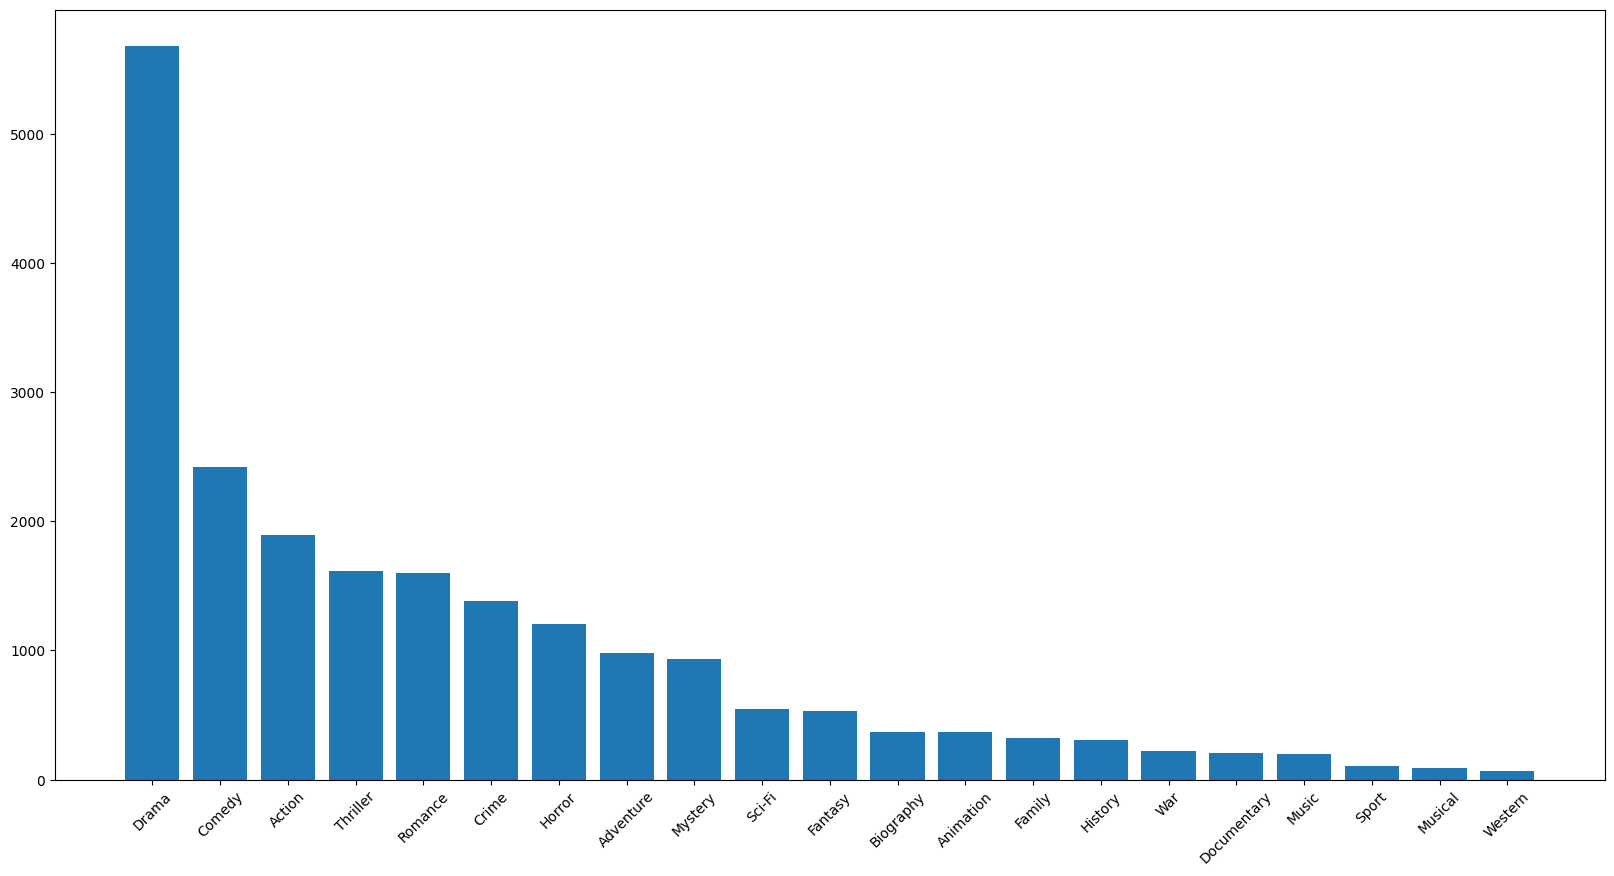

In [6]:
# 각 장르별 영화 개수 plot
import matplotlib.pyplot as plt

genre_count = {}
for genres in movie_genres.values():
    for genre in genres:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_count = dict(sorted(genre_count.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(20, 10))
plt.bar(genre_count.keys(), genre_count.values())
plt.xticks(rotation=45)
plt.show()

In [7]:
genre_count

{'Drama': 5682,
 'Comedy': 2423,
 'Action': 1891,
 'Thriller': 1618,
 'Romance': 1603,
 'Crime': 1380,
 'Horror': 1208,
 'Adventure': 978,
 'Mystery': 933,
 'Sci-Fi': 545,
 'Fantasy': 534,
 'Biography': 368,
 'Animation': 367,
 'Family': 322,
 'History': 307,
 'War': 224,
 'Documentary': 209,
 'Music': 200,
 'Sport': 106,
 'Musical': 93,
 'Western': 66}

In [14]:
import numpy as np

for genre in genre_count.keys():
    print(f"Genre: {genre}")
    print(df_for_genres_based_recommend[df_for_genres_based_recommend['genres'].str.contains(genre)].index)
    # store indexs of df_for_genres_based_recommend by genre in npy file
    np.save(f"./genre_index/{genre}_indexs.npy", df_for_genres_based_recommend[df_for_genres_based_recommend['genres'].str.contains(genre)].index)

Genre: Drama
Index([   0,    1,    6,    8,    9,   11,   12,   14,   15,   17,
       ...
       9513, 9514, 9515, 9516, 9518, 9519, 9521, 9522, 9523, 9524],
      dtype='int64', length=5682)
Genre: Comedy
Index([   6,   10,   14,   15,   18,   25,   28,   34,   36,   40,
       ...
       9485, 9489, 9495, 9496, 9499, 9506, 9509, 9512, 9517, 9520],
      dtype='int64', length=2423)
Genre: Action
Index([   4,    6,    7,    9,   17,   23,   32,   34,   36,   55,
       ...
       9375, 9402, 9407, 9408, 9436, 9439, 9447, 9469, 9517, 9518],
      dtype='int64', length=1891)
Genre: Thriller
Index([   2,    3,    4,    5,   16,   31,   48,   50,   53,   61,
       ...
       9369, 9372, 9376, 9379, 9387, 9406, 9409, 9454, 9459, 9505],
      dtype='int64', length=1618)
Genre: Romance
Index([   8,   11,   12,   18,   25,   40,   43,   44,   46,   48,
       ...
       9500, 9501, 9506, 9508, 9509, 9511, 9514, 9518, 9522, 9524],
      dtype='int64', length=1603)
Genre: Crime
Index([   4,   

In [21]:
comedy_indexs = np.load("./genre_index/Comedy_indexs.npy")
df_for_genres_based_recommend.iloc[comedy_indexs]

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,ordering,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
6,tt30364726,Citizen of a Kind,Citizen of a Kind,2024,114,"Action,Comedy,Drama",6.4,28,nm8142058,1,...,0.040804,-0.034095,-0.025141,0.009517,-0.059825,0.071487,0.111060,-0.062704,0.009305,-0.002621
10,tt29579010,It's Okay!,It's Okay!,2023,102,"Comedy,Family",7.7,16,nm13767046,1,...,0.048707,-0.011220,-0.018363,0.027554,-0.105131,0.064523,0.016868,0.002069,0.039751,0.004803
14,tt13814704,Dream,Deurim,2023,125,"Comedy,Drama,Sport",6.5,3049,nm4998869,10,...,-0.007062,-0.093492,-0.015759,0.165195,-0.005052,0.023758,0.002638,-0.017882,-0.024570,-0.045752
15,tt29259250,Miss Fortune,Hwasahan geunyeo,2023,121,"Comedy,Drama",6.0,36,nm15283160,1,...,0.026224,-0.057555,-0.018167,0.089604,0.030709,0.025764,0.126016,-0.078456,-0.008939,-0.021327
18,tt29031019,Love Reset,30 il,2023,119,"Comedy,Romance",6.9,1160,nm4647793,10,...,-0.001420,-0.005903,0.113477,0.031280,-0.072565,-0.035299,0.059401,0.111517,0.006717,-0.023393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9506,tt0021749,City Lights,City Lights,1931,87,"Comedy,Drama,Romance",8.5,194969,nm0000122,1,...,0.009962,-0.128484,-0.048821,0.080210,0.024267,-0.016587,0.008518,-0.012990,-0.001089,0.040829
9509,tt0022125,Marius,Marius,1931,130,"Comedy,Drama,Romance",7.8,2546,nm0466099,1,...,0.032562,-0.101574,-0.046514,0.048880,-0.003156,0.007474,0.010705,0.011225,-0.065067,0.029740
9512,tt0019901,Woman in the Moon,Frau im Mond,1929,156,"Adventure,Comedy,Drama",7.2,3830,nm0000485,1,...,0.034414,0.033320,-0.048615,0.024125,-0.054621,-0.007618,0.093863,0.014121,-0.029125,-0.041370
9517,tt0018937,A Girl in Every Port,A Girl in Every Port,1928,78,"Action,Adventure,Comedy",6.6,806,nm0001328,1,...,0.002516,0.012719,-0.058167,0.066921,-0.000899,0.053774,-0.005466,-0.052637,0.048695,0.015760


In [26]:
movie_features = torch.from_numpy(np.load("final_features_without_directors_0518.npy")).float()
movie_features[comedy_indexs].shape

torch.Size([2423, 404])

In [28]:
comedy_indexs.shape[0]

2423

In [47]:
import numpy as np

# 유저 임베딩 생성 함수
def create_new_user_embedding(movie_features, interacted_movie_indices):
    new_user_embedding = movie_features[interacted_movie_indices].mean(dim=0)
    # print("new user embedding shape:", new_user_embedding.shape)
    # print("new user embedding:", new_user_embedding)
    return new_user_embedding

# 새로운 유저에 대한 영화 추천
def recommend_movies_for_new_user(node_embeddings, num_users = 1, num_movies = 9525, num_recommendations=5):
    movie_indices = torch.arange(num_users, num_users + num_movies) # 영화 인덱스 생성 (유저 수만큼 offset)
    
    # user-movie pairs 생성
    user_movie_pairs = torch.stack([torch.zeros(num_movies, dtype=torch.long), movie_indices], dim=0)
    print(user_movie_pairs)
    
    # user-movie pairs의 score 계산
    scores = link_predictor(node_embeddings, user_movie_pairs)
    # print(scores[scores > 0.9])
    
    # top N 추천
    _, top_indices = torch.topk(scores.squeeze(), num_recommendations)
    top_movie_indices = user_movie_pairs[1][top_indices] - num_users # 유저 수만큼 offset 재조정
    
    return top_movie_indices


# 영화 features
movie_features = torch.from_numpy(np.load("final_features_without_directors_0518.npy")).float()

# 새로운 유저가 6076, 9519 영화를 시청했다고 가정
new_user_interacted_movies = [6076, 9519] # 점퍼, 메트로폴리스
# new_user_interacted_movies = [4887, 5839] # 7번 방의 선물, 세 얼간이
# new_user_interacted_movies = [6, 10, 14] # Citizen of a Kind, It's Okay!, Deurim (코미디들)
new_user_embedding = create_new_user_embedding(movie_features, new_user_interacted_movies)

new_x = torch.cat([new_user_embedding.view(1, -1), movie_features], dim=0)
num_users = 1

# 유저 - 영화 간 상호작용 edge index로 변환
user_indices = [i for i in range(num_users)]
movie_indices = [i + num_users for i in new_user_interacted_movies]

edge_index = torch.tensor([user_indices * len(movie_indices), movie_indices], dtype=torch.long)

node_embeddings = gcn_model(new_x, edge_index)
node_embeddings = torch.cat([node_embeddings[:num_users], node_embeddings[num_users:][comedy_indexs]], dim=0) # 코미디 영화만 추천
print(node_embeddings.shape)

# 새로운 유저에 대한 추천 수행
num_recommendations = 20
top_movies_for_new_user = recommend_movies_for_new_user(node_embeddings, num_movies=comedy_indexs.shape[0], num_recommendations=num_recommendations)
top_movies_for_new_user = comedy_indexs[top_movies_for_new_user]
print(f"Top {num_recommendations} recommended movies for the new user: {top_movies_for_new_user}")
for idx in top_movies_for_new_user:
    print(final_metadata.iloc[int(idx)].genres)
    print(movie_metadata.iloc[int(idx)].overview)

torch.Size([2424, 404])
tensor([[   0,    0,    0,  ...,    0,    0,    0],
        [   1,    2,    3,  ..., 2421, 2422, 2423]])
Top 20 recommended movies for the new user: [ 875 2702 2135 7908 3848 8623 4749 8686  179  376 4881 1052 2307 4027
 4079 4828 3369 3098 9228 1104]
Comedy,Horror,Mystery
이웃 사촌이자 친구인 존과 레비는 LA의 한 아파트 건물에서 초자연적인 사건을 목격하고, 그 초자연적인 현상을 기록하여 무료한 삶에서 벗어나 명성과 돈을 얻고자 한다. 하지만 점점 더 깊고 어두운 심연에서 벌어지는 현상속에서 서로에 대한 위험성이 드러나면서, 그들의 우정은 점점 금이 간다.
Comedy,Horror,Sci-Fi
80년대 후반과 90년대 초반의 배경으로 어느날 주인공 소녀 '미미'와 '루크'가 수백만년 전 우주를 파괴하려는 시도를 했다가 실패한 후에 지구에 묻힌 고대 외계인 지배자를 부활시키게 되면서 벌어지는 이야기
Comedy,Horror,Sci-Fi
LA에서 있을 줄리아의 스탠드업 공연을 위해 길을 떠난 줄리아와 카일은 타이어 펑크로 차가 멈추자 뜻하지 않게 폐허가 된 유령 도시에서 밤을 보내게 된다. 그리고 그곳에서 선사시대 포식자인 랩터를 마주하게 되는데...
Comedy,Horror,Sci-Fi
nan
Comedy,Horror,Mystery
생일날 반복되는 죽음이라는 특별한 선물을 받은 여대생의 끝나지 않는 파티
Comedy,Horror,Sci-Fi
피서지로 유명한 호반에서 무전 여행을 하던 남녀가 행방 불명되는 사건이 발생한다. 조사에 나선 사립탐정 매기(Maggie McKeown: 헤더 멘지스 분)는 정부의 연구기관에서 비밀리에 식인어 피라나를 사육하고 있었음을 밝혀낸다. 찬물에 강하고 놀라운 번식력을 가진 변